# Step 2: Exploratory Data Analysis (EDA) and Initial Preprocessing

## Purpose
The purpose of this notebook is to perform Exploratory Data Analysis (EDA) on the filtered Open Food Facts dataset (`food.csv`) produced in Step 1. We want to understand the data structure, distributions, and relationships between features, and to identify any data quality issues before preprocessing.

---

#### Dataset Download
Run `1_data_extraction.ipynb` to download the dataset `food.csv`.

## Tasks

### Data Exploration
- Determine the number of observations in the dataset.
- Describe all columns, including:
  - Variable type (categorical, continuous, text, etc.)
  - Scale (nominal, ordinal, ratio)
  - Data distributions (summary statistics, value counts)
- Identify the target column (`nutriscore_grade`) and describe its classes.
- Detect missing values and duplicate rows.
- For text fields or semi-structured JSON columns, provide a summary of content (e.g., most common ingredients or labels).

### Data Plots
- Visualize the data using bar charts, pie charts, histograms, scatter plots, or other appropriate plots.
- Highlight insights from the plots, such as:
  - Distribution of Nutri-Score grades
  - Frequency of top categories, product, or ingredients
  - Relationships between numeric features (e.g., sugar, fat, energy)
  

> Note: For image datasets, include examples of classes, image counts, sizes, and preprocessing requirements (cropping, resizing, normalization).  

### Preprocessing Plan
- Explain how you plan to preprocess the data in the next step, including:
  - Handling missing values
  - Normalizing or scaling continuous features
  - Encoding categorical variables
  - Handling class imbalance in the target variable
- Do not perform preprocessing here; this will be implemented in Step 3.  

---

## Output
- Insights and summary statistics from EDA.
- Visualizations showing distributions and relationships in the data.
- Documentation of data quality issues and preprocessing plan.

EDA results and preprocessing plan can be found in [Preprocessing_Deliverable.md](https://github.com/swhoyle/food-nutrition-model/blob/main/documentation/Preprocessing_Deliverable.md)

In [251]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast
from collections import Counter

Load Dataset

In [ ]:
dataset_path = "../data/food.csv"

# check that it exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File not found: {dataset_path}\nUse !ls ../data to check available files.")

# Load dataset
df = pd.read_csv(dataset_path, low_memory=False)
print(f" Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

### Initial Analysis

In [ ]:
# Number of rows and columns
rows, cols = df.shape
print(f"Dataset contains {rows:,} observations and {cols} features.")

Dataset contains 424,297 observations and 24 features.


In [ ]:
# Display data types
df.dtypes

code                            object
brands                          object
product                         object
lang                            object
categories_tags                 object
food_groups_tags                object
labels_tags                     object
additives_n                    float64
additives_tags                  object
allergens_tags                  object
ingredients_analysis_tags       object
ingredients_n                  float64
ingredients_from_palm_oil_n    float64
ingredients                     object
completeness                   float64
energy                         float64
sugars                         float64
added_sugars                   float64
carbohydrates                  float64
salt                           float64
fat                            float64
trans_fat                      float64
proteins                       float64
nutriscore_grade                object
dtype: object

In [ ]:
# Summary statistics for numeric columns
num_cols = ["additives_n","ingredients_n","ingredients_from_palm_oil_n","completeness","energy","sugars","added_sugars","carbohydrates","salt","fat","trans_fat","proteins"]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,424296.0,2.172512e+00,3.143536e+00,0.00,0.000000,1.00,3.00,3.900000e+01
ingredients_n,424296.0,1.592136e+01,1.704974e+01,0.00,4.000000,11.00,21.00,7.510000e+02
ingredients_from_palm_oil_n,338465.0,1.078398e-03,3.344550e-02,0.00,0.000000,0.00,0.00,2.000000e+00
completeness,424297.0,5.573207e-01,1.323190e-01,0.20,0.475000,0.55,0.60,1.100000e+00
energy,420317.0,1.467027e+14,9.511006e+16,0.00,354.000000,1100.00,1790.00,6.166162e+19
sugars,411261.0,2.431564e+06,1.559341e+09,-1.45,1.180000,5.04,22.67,1.000000e+12
added_sugars,24834.0,1.275623e+01,9.899108e+01,0.00,0.000000,0.00,11.20,9.000000e+03
carbohydrates,419493.0,1.183488e+25,7.665248e+27,0.00,6.250000,22.40,58.50,4.964649e+30
salt,420181.0,3.856932e+00,6.019403e+02,0.00,0.025900,0.45,1.25,3.559425e+05
fat,420295.0,1.105549e+20,7.167291e+22,0.00,0.000000,5.90,21.00,4.646567e+25


Numeric columns (nutrients and counts) are right-skewed, with many low values and a few extreme outliers.

- `energy` values vary widely, suggesting mixed units (kcal vs kJ) — will need normalization later.
- `completeness` averages around 0.6, meaning most records are moderately detailed.

In [ ]:
# Summary statistics for categorical columns
# View value counts for key categorical variables
cat_cols = ["brands","categories_tags","labels_tags","lang","nutriscore_grade"]
for c in cat_cols:
    print(f"\nTop categories for {c}:")
    print(df[c].value_counts().head(5))


Top categories for brands:
brands
Wawa                  2544
Tesco                 2449
Great Value           2023
Meijer                1908
Jersey Mike's Subs    1828
Name: count, dtype: int64

Top categories for categories_tags:
categories_tags
['undefined']                                            32335
['snacks']                                               31113
['snacks', 'sweet-snacks', 'confectioneries']            12933
['condiments', 'sauces', 'groceries']                    10948
['beverages-and-beverages-preparations', 'beverages']    10697
Name: count, dtype: int64

Top categories for labels_tags:
labels_tags
[]                                27360
['organic']                       11326
['no-gluten']                      6933
['no-gmos', 'non-gmo-project']     6765
['vegetarian', 'vegan']            4083
Name: count, dtype: int64

Top categories for lang:
lang
en    424297
Name: count, dtype: int64

Top categories for nutriscore_grade:
nutriscore_grade
e    134562
d 

- `Brands`: Highly diverse, thousands of unique brands.
- `Categories`: Common tags include snacks, sweet-snacks, condiments, sauces, groceries, beverages, and etc.
- `Labels`: sparse, most entries lack label tags.
- `Language`: Filtered for English (en).
- `Nutri-Score` (target): All five grades (A–E) are represented.

### Column Analysis

In [ ]:
df.columns

Index(['code', 'brands', 'product', 'lang', 'categories_tags',
       'food_groups_tags', 'labels_tags', 'additives_n', 'additives_tags',
       'allergens_tags', 'ingredients_analysis_tags', 'ingredients_n',
       'ingredients_from_palm_oil_n', 'ingredients', 'completeness', 'energy',
       'sugars', 'added_sugars', 'carbohydrates', 'salt', 'fat', 'trans_fat',
       'proteins', 'nutriscore_grade'],
      dtype='object')

##### `code`: Unique product code

In [ ]:
print('Number of unique codes:', df["code"].nunique())
print('Number of duplicated codes:', df["code"].duplicated().sum())
df["code"].head()

Number of unique codes: 424297
Number of duplicated codes: 0


0    0000105000417
1    0000111048403
2    0000111301201
3    0000111301263
4    0000127534587
Name: code, dtype: object

code is a unique identifier for each row / product. There are no duplicates.

##### `brands`: Brand name of the food product

Number of unique brands: 59855

Statistics for number of products per brand:
count    59855.000000
mean         5.135043
std         36.524418
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2544.000000
Name: count, dtype: float64


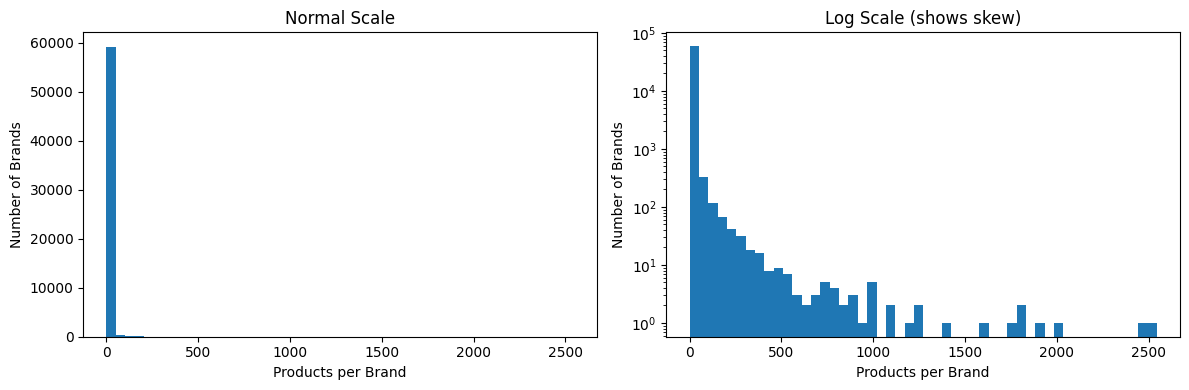


Top 10 most common brands:
                    Count Percentage
brands                              
Wawa                 2544      0.83%
Tesco                2449       0.8%
Great Value          2023      0.66%
Meijer               1908      0.62%
Jersey Mike's Subs   1828      0.59%
Papa John's          1804      0.59%
Kroger               1764      0.57%
Sheetz               1607      0.52%
Trader Joe's         1398      0.45%
Asda                 1232       0.4%


In [ ]:
print('Number of unique brands:', df["brands"].nunique())

print("\nStatistics for number of products per brand:")
print(df["brands"].value_counts().describe())

# Histogram of products per brand
brand_count = df['brands'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: normal scale
axes[0].hist(brand_count, bins=50)
axes[0].set_title('Normal Scale')
axes[0].set_xlabel('Products per Brand')
axes[0].set_ylabel('Number of Brands')

# Right: log scale (shows skew clearly)
axes[1].hist(brand_count, bins=50)
axes[1].set_yscale('log')
axes[1].set_title('Log Scale (shows skew)')
axes[1].set_xlabel('Products per Brand')
axes[1].set_ylabel('Number of Brands')

plt.tight_layout()
plt.show()

print("\nTop 10 most common brands:")
brand_counts = df["brands"].value_counts()
brand_percentages = df["brands"].value_counts(normalize=True)
top_10_brands = pd.DataFrame({"Count": brand_counts, "Percentage": round(brand_percentages * 100, 2).astype(str) + "%"}).head(10)
print(top_10_brands)



A few brands dominate the dataset.
This could bias learning toward those brands if not handled properly (e.g., randomizing or excluding brand identifiers during model training). However, no brand has more than 1% of the products in the dataset so it isn't too concerning.

##### `product`: Name of the food product

Number of unique products: 294108

Statistics for number of products per brand:
count    294108.000000
mean          1.442616
std           5.421838
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2163.000000
Name: count, dtype: float64


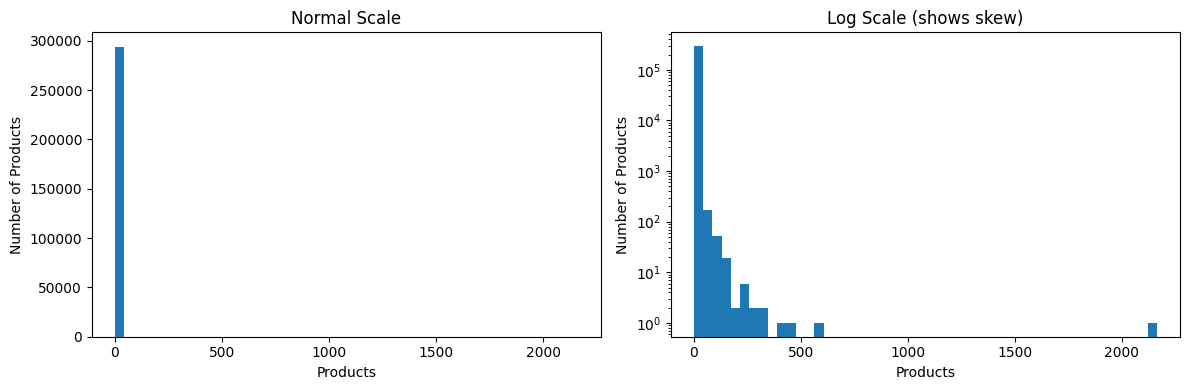


Top 10 most common products:
                        Count Percentage
product                                 
[]                       2163      0.51%
Ice cream                 583      0.14%
Soda                      460      0.11%
Ice Cream                 415       0.1%
Extra Virgin Olive Oil    336      0.08%
Potato chips              317      0.07%
Potato Chips              275      0.06%
Popcorn                   272      0.06%
Cookies                   240      0.06%
Premium ice cream         239      0.06%


In [ ]:
print('Number of unique products:', df["product"].nunique())

print("\nStatistics for number of products per brand:")
print(df["product"].value_counts().describe())

# Histogram of products per brand
brand_count = df['product'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: normal scale
axes[0].hist(brand_count, bins=50)
axes[0].set_title('Normal Scale')
axes[0].set_xlabel('Products')
axes[0].set_ylabel('Number of Products')

# Right: log scale (shows skew clearly)
axes[1].hist(brand_count, bins=50)
axes[1].set_yscale('log')
axes[1].set_title('Log Scale (shows skew)')
axes[1].set_xlabel('Products')
axes[1].set_ylabel('Number of Products')

plt.tight_layout()
plt.show()

print("\nTop 10 most common products:")
product_counts = df["product"].value_counts()
product_percentages = df["product"].value_counts(normalize=True)
top_10_products = pd.DataFrame({"Count": product_counts, "Percentage": round(product_percentages * 100, 2).astype(str) + "%"}).head(10)
print(top_10_products)



There are products with the exact same name. However, this doesn't look like an issue as many are generic names, such as "Ice cream" and "Popcorn". We should investigate that each product has a unique brand + product name. 

In [ ]:
# check for duplicate brand + product combinations
dup_counts = df.groupby(["brands", "product"]).size().reset_index(name="counts")
dup_brand_product = dup_counts[dup_counts["counts"] > 1].sort_values(by="counts", ascending=False)
print(f"Number of duplicate brand + product combinations: {len(dup_brand_product)}")
dup_brand_product

Number of duplicate brand + product combinations: 24763


,brands,product,counts
102206,Heinz,Tomato Ketchup,37
258462,Weis,Premium Ice Cream,34
264882,"Wilton, Wilton Enterprises Inc","Wilton, icing decorations",33
253328,Waitrose,[],31
235706,Tesco,[],29
...,...,...,...
167934,O'Charley's,"O'Charley's, French Silk Pie",2
167933,O'Charley's,"O'Charley's, French Fries, Kids",2
167932,O'Charley's,"O'Charley's, French Fries",2
167931,O'Charley's,"O'Charley's, Double Crust Cherry Pie, Whole",2


We identified ~25,000 duplicate brand + product combinations. These may be true duplicates or distinct product variations. To reduce noise and bias, we can keep only the record with the highest completion % for identical duplicates while preserving unique variations (e.g., different sizes or formats). This ensures the dataset contains high-quality, unique product entries for modeling.


In [ ]:
# Example of duplicate brand/product name entries and their completeness
df[(df["brands"] == "Heinz") & (df["product"] == "Tomato Ketchup")].sort_values(by="completeness", ascending=False).head(3)

,code,brands,product,lang,categories_tags,food_groups_tags,labels_tags,additives_n,additives_tags,allergens_tags,...,completeness,energy,sugars,added_sugars,carbohydrates,salt,fat,trans_fat,proteins,nutriscore_grade
149937,50457250,Heinz,Tomato Ketchup,en,"['condiments', 'sauces', 'tomato-sauces', 'ket...","['fats-and-sauces', 'dressings-and-sauces']","['no-gluten', 'vegetarian', 'no-artificial-fla...",0.0,[],['celery'],...,1.0000,435.0,22.799999,NaN,23.200001,1.80,0.1,NaN,1.2,d
95572,01312403,Heinz,Tomato Ketchup,en,"['condiments', 'specific-products', 'products-...","['fats-and-sauces', 'dressings-and-sauces']","['no-gluten', 'kosher', 'orthodox-union-kosher']",0.0,[],[],...,0.9875,494.0,23.500000,23.5,NaN,2.65,0.0,0.0,0.0,e
57671,0057000013165,Heinz,Tomato Ketchup,en,"['condiments', 'sauces', 'tomato-sauces', 'ket...","['fats-and-sauces', 'dressings-and-sauces']","['kosher', 'orthodox-union-kosher']",0.0,[],[],...,0.9875,560.0,26.700001,NaN,33.299999,2.33,0.0,0.0,2.0,d


##### `lang`: Language of the product

In [ ]:
df["lang"].value_counts()

lang
en    424297
Name: count, dtype: int64

All products are in english (en) language

##### `categories_tags`: List of category tags

In [ ]:
df["categories_tags"].head()

0    ['plant-based-foods-and-beverages', 'beverages...
1    ['plant-based-foods-and-beverages', 'plant-bas...
2                                          ['dairies']
3                                             ['fats']
4                                             ['null']
Name: categories_tags, dtype: object

categories_tags count statistics:
count    424297.000000
mean          3.730552
std           2.699415
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max          31.000000
Name: num_categories_tags, dtype: float64

Number of unique categories_tags: 18026


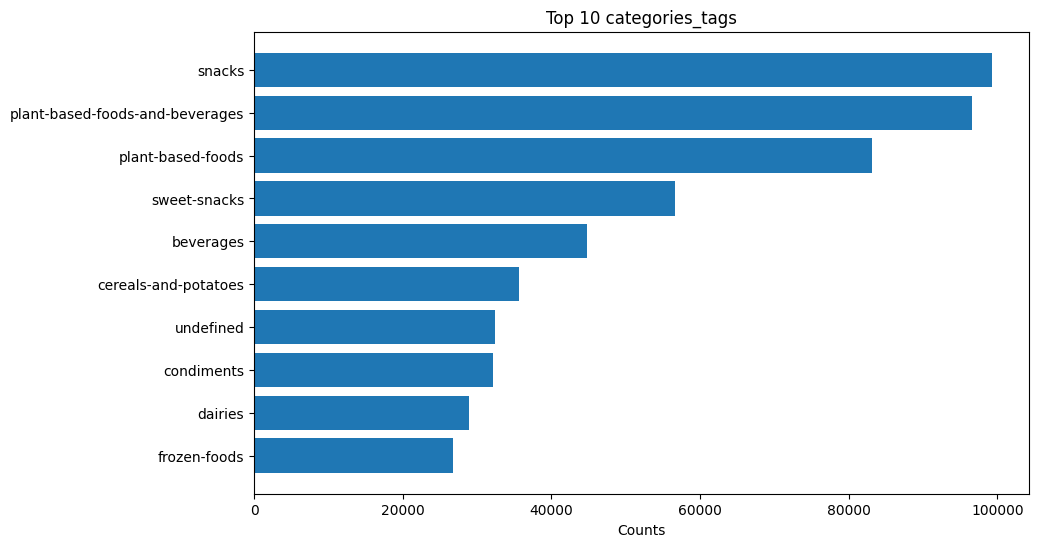


Saved categories_tags counts to ../data/categories_tags_counts.json


In [ ]:
def tag_analysis(tag_column):

    df[f"num_{tag_column}"] = df[tag_column].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)
    print(f"{tag_column} count statistics:")
    print(df[f"num_{tag_column}"].describe())

    tag_counts = Counter()

    for tags in df[tag_column].dropna():
        if isinstance(tags, str):
            tags = ast.literal_eval(tags)
        for tag in tags:
            tag_counts[tag] += 1

    # Number of unique tags
    print(f"\nNumber of unique {tag_column}: {len(tag_counts)}")

    # Plot Top 10 tags
    top_tags, top_counts = zip(*tag_counts.most_common(10))
    plt.figure(figsize=(10, 6))
    plt.barh(top_tags, top_counts)
    plt.xlabel('Counts')
    plt.title(f'Top 10 {tag_column}')
    plt.gca().invert_yaxis()  # Highest count on top
    plt.show()

    # save tag counts to json (sorted)
    with open(f"../data/{tag_column}_counts.json", "w") as f:
        json.dump(dict(sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)), f)

    print(f"\nSaved {tag_column} counts to ../data/{tag_column}_counts.json")

tag_analysis("categories_tags")

##### `food_groups_tags`: List of food group tags

In [ ]:
df["food_groups_tags"].head()

0    ['beverages', 'unsweetened-beverages']
1               ['fats-and-sauces', 'fats']
2                                        []
3               ['fats-and-sauces', 'fats']
4                                        []
Name: food_groups_tags, dtype: object

food_groups_tags count statistics:
count    424297.000000
mean          1.386906
std           0.952213
min           0.000000
25%           0.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: num_food_groups_tags, dtype: float64

Number of unique food_groups_tags: 52


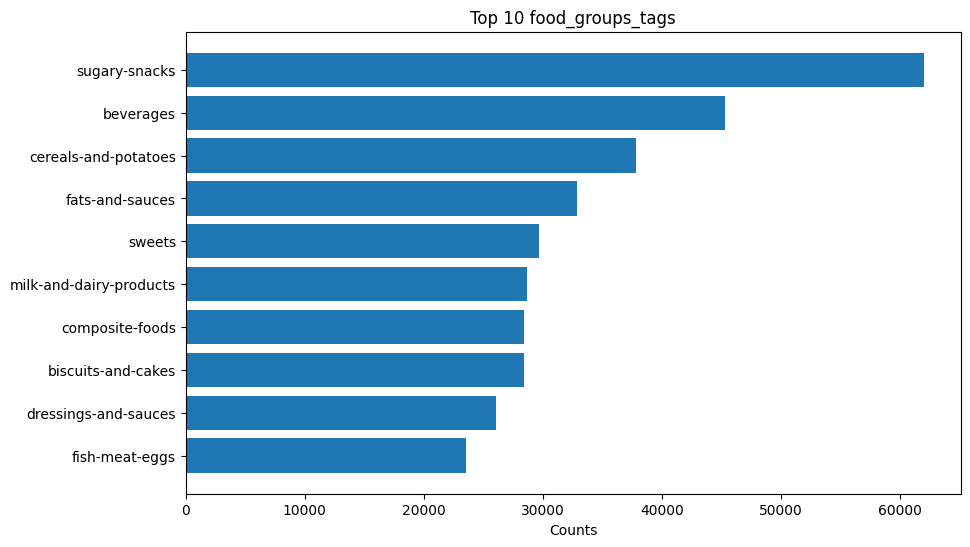


Saved food_groups_tags counts to ../data/food_groups_tags_counts.json


In [ ]:
tag_analysis("food_groups_tags")

##### `labels_tags`: List of label tags

labels_tags count statistics:
count    424297.000000
mean          0.549346
std           1.443633
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: num_labels_tags, dtype: float64

Number of unique labels_tags: 5428


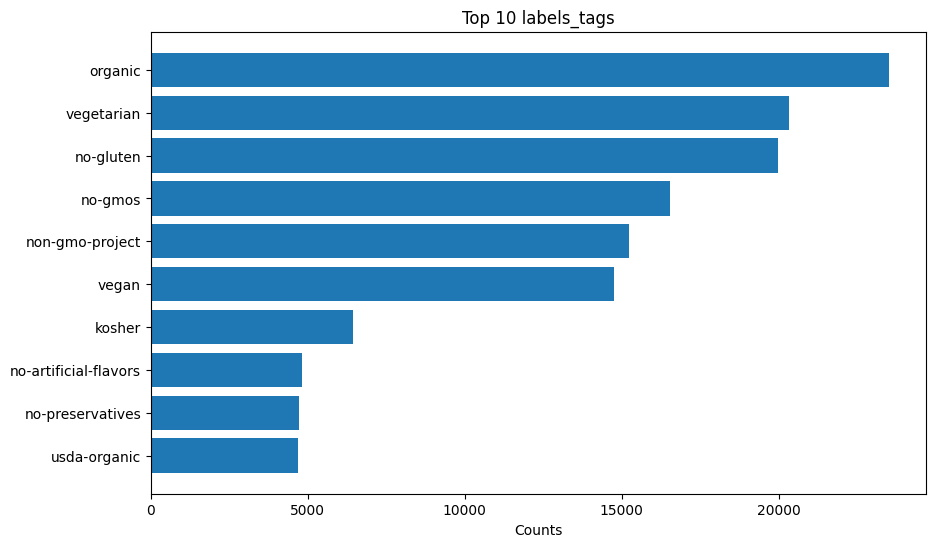


Saved labels_tags counts to ../data/labels_tags_counts.json


In [ ]:
tag_analysis("labels_tags")

##### `additives_tags`: List of additive tags

additives_tags count statistics:
count    424297.000000
mean          2.534807
std           3.682433
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          42.000000
Name: num_additives_tags, dtype: float64

Number of unique additives_tags: 540


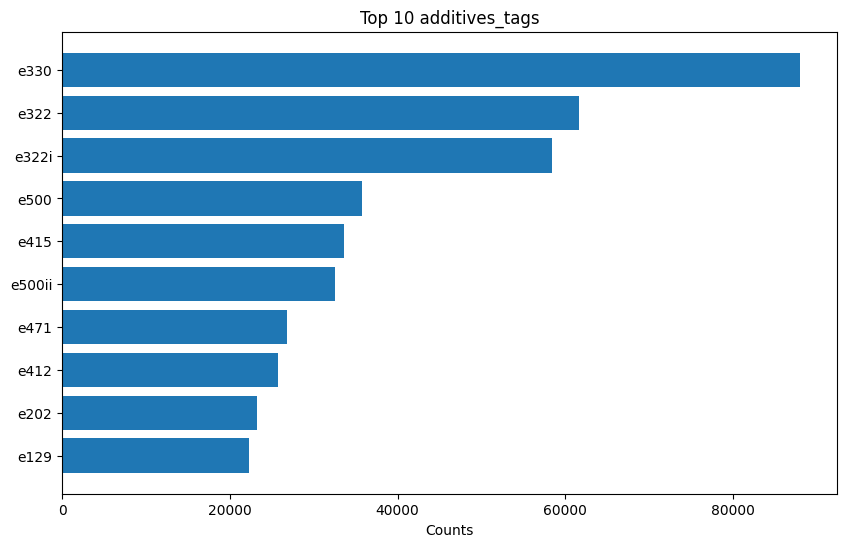


Saved additives_tags counts to ../data/additives_tags_counts.json


In [ ]:
tag_analysis("additives_tags")

##### `additives_n`: Number of additives

In [ ]:
df["additives_n"].describe()

count    424296.000000
mean          2.172512
std           3.143536
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          39.000000
Name: additives_n, dtype: float64

Products with no additives: 181255 (42.72%)
Products with additives: 243041 (57.28%)


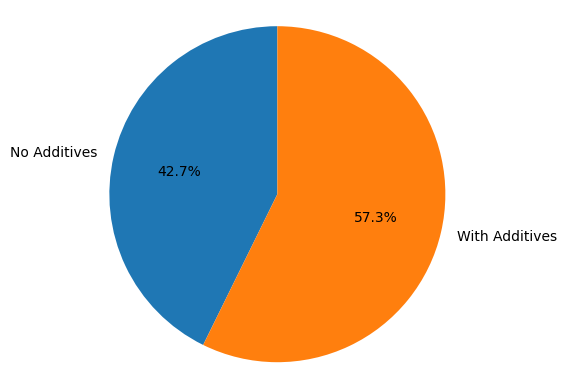

In [ ]:
# Show percent of product with no additives vs additives (plot)

no_additives = (df["additives_n"] == 0).sum()
with_additives = (df["additives_n"] > 0).sum()
total = no_additives + with_additives
print(f"Products with no additives: {no_additives} ({(no_additives/total)*100:.2f}%)")
print(f"Products with additives: {with_additives} ({(with_additives/total)*100:.2f}%)")

# Plot
labels = ['No Additives', 'With Additives']
sizes = [no_additives, with_additives]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

##### `allergens_tags`: List of allergen tags

allergens_tags count statistics:
count    424297.000000
mean          1.165269
std           1.357117
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          19.000000
Name: num_allergens_tags, dtype: float64

Number of unique allergens_tags: 1006


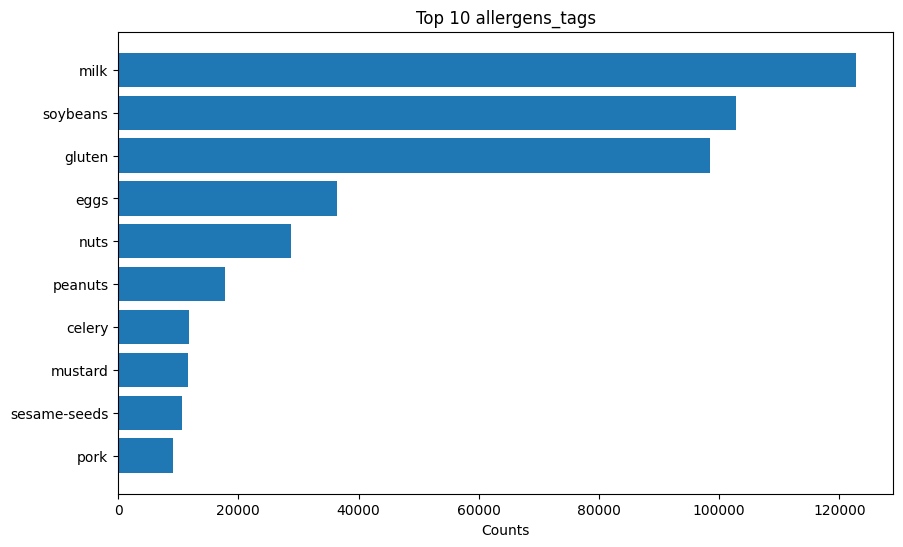


Saved allergens_tags counts to ../data/allergens_tags_counts.json


In [ ]:
tag_analysis("allergens_tags")

##### `ingredients_ananlysis_tags`: List of ingredients analysis tags

ingredients_analysis_tags count statistics:
count    424297.000000
mean          2.999239
std           0.046987
min           0.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: num_ingredients_analysis_tags, dtype: float64

Number of unique ingredients_analysis_tags: 12


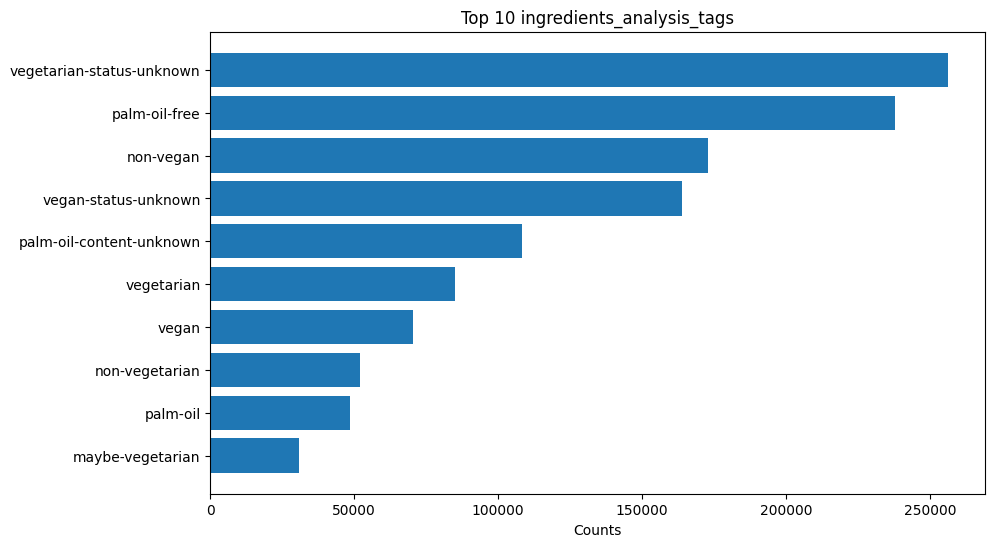


Saved ingredients_analysis_tags counts to ../data/ingredients_analysis_tags_counts.json


In [ ]:
tag_analysis("ingredients_analysis_tags")

##### `ingredients_n`: Number of ingredients

count    424296.000000
mean         15.921364
std          17.049743
min           0.000000
25%           4.000000
50%          11.000000
75%          21.000000
max         751.000000
Name: ingredients_n, dtype: float64


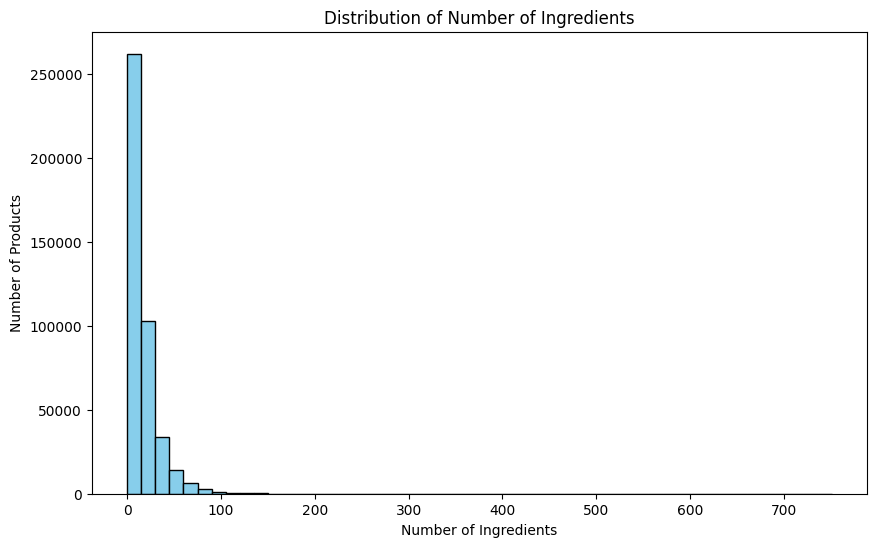

In [ ]:
# summary statistics for ingredients_n
print(df["ingredients_n"].describe())

# plot distribution of ingredients_n
plt.figure(figsize=(10, 6))
plt.hist(df["ingredients_n"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Ingredients')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Products')
plt.show()

In [ ]:
# 0 ingredients
zero_ingredients = df[df["ingredients_n"] == 0]
print(f"Number of products with 0 ingredients: {len(zero_ingredients)}")
zero_ingredients[["product", "ingredients_n", "ingredients"]].head()

Number of products with 0 ingredients: 114


,product,ingredients_n,ingredients
7633,American Wild Shrimp,0.0,[]
11813,Seasoned Panko Bread Crumbs,0.0,[]
11814,Italian Panko Breadcrumbs,0.0,[]
11815,Dry Aged Beef Panko Breadcrumbs,0.0,[]
11816,Classic Home-Style Meatball,0.0,[]


In [ ]:
# check if ingredients_n correlates matches number of ingredients
df["ingredients_count"] =  df["ingredients"].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)
mismatch_ingredient_count = df[df["ingredients_n"] !=  df["ingredients_count"]]
pct_mismatch = (len(mismatch_ingredient_count) / len(df)) * 100
print(f"Number of products with mismatched ingredients_n and actual count: {len(mismatch_ingredient_count)} ({pct_mismatch:.2f}%)")
mismatch_ingredient_count[["product", "ingredients_n", "ingredients_count", "ingredients"]].head()

Number of products with mismatched ingredients_n and actual count: 260563 (61.41%)


,product,ingredients_n,ingredients_count,ingredients
2,Canola Harvest® Original Vegetable Oil Spread Tub,17.0,15,"['canola oil', 'water', 'palm oil', 'palm kern..."
3,"Canola harvest, buttery spread, with flaxseed oil",20.0,17,"['canola oil', 'water', 'palm oil', 'flax oil'..."
5,"Bakers Best, White Bread",33.0,20,"['flour', 'water', 'sugar', 'yeast', 'ethoxyla..."
6,"Bakers Best, Rye Bread",18.0,11,"['flour', 'water', 'yeast', 'sugar', 'soy oil'..."
7,"Piasten, Chocolate Assortment",31.0,26,"['sugar', 'wheat starch', 'glucose syrup', 'so..."


##### `ingredients_from_palm_oil_n`: Number of ingredients from palm oil

count    338465.000000
mean          0.001078
std           0.033446
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: ingredients_from_palm_oil_n, dtype: float64


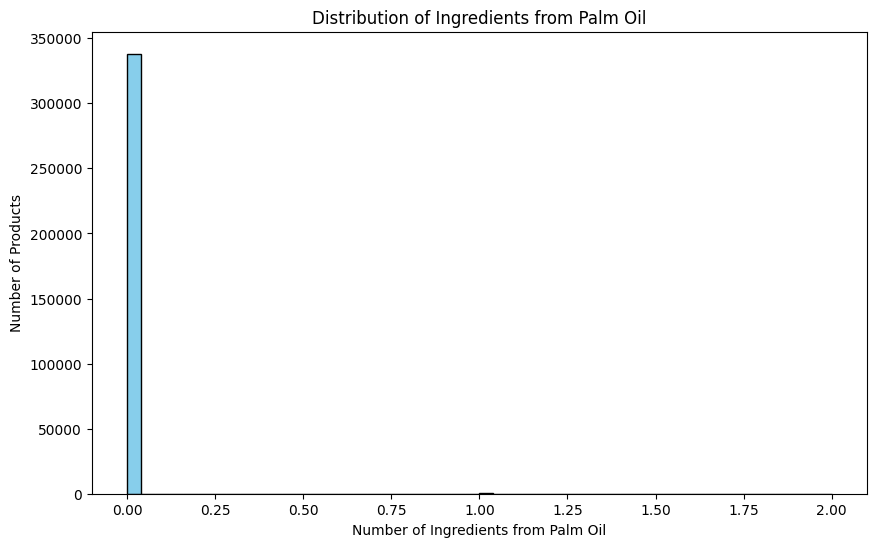

In [ ]:
# summary statistics for ingredients_from_palm_oil_n
print(df["ingredients_from_palm_oil_n"].describe())

# plot distribution of ingredients_from_palm_oil_n
plt.figure(figsize=(10, 6))
plt.hist(df["ingredients_from_palm_oil_n"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Ingredients from Palm Oil')
plt.xlabel('Number of Ingredients from Palm Oil')
plt.ylabel('Number of Products')
plt.show()

Products with palm oil ingredients: 358 (0.11%)
Products without palm oil ingredients: 338107 (99.89%)


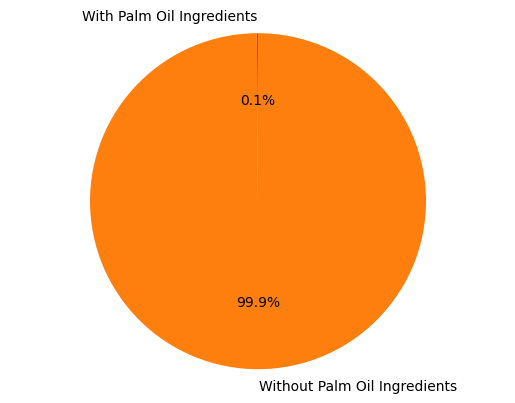

In [ ]:
# Has palm oil ingredients
has_palm_oil = (df["ingredients_from_palm_oil_n"] > 0).sum()
no_palm_oil = (df["ingredients_from_palm_oil_n"] == 0).sum()
total = has_palm_oil + no_palm_oil
print(f"Products with palm oil ingredients: {has_palm_oil} ({(has_palm_oil/total)*100:.2f}%)")
print(f"Products without palm oil ingredients: {no_palm_oil} ({(no_palm_oil/total)*100:.2f}%)")

# Plot
labels = ['With Palm Oil Ingredients', 'Without Palm Oil Ingredients']
sizes = [has_palm_oil, no_palm_oil]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

##### `ingredients`: List of ingredients

In [ ]:
df["ingredients"].head()

0    ['andropogon citratus', 'uva ursi', 'hibiscus ...
1         ['canola oil no additives', 'preservatives']
2    ['canola oil', 'water', 'palm oil', 'palm kern...
3    ['canola oil', 'water', 'palm oil', 'flax oil'...
4    ['rye flour', 'water', 'wheat', 'flour', 'malt...
Name: ingredients, dtype: object

##### `completeness`: Completeness of product data (%)

In [ ]:
df["completeness"].describe()

count    424297.000000
mean          0.557321
std           0.132319
min           0.200000
25%           0.475000
50%           0.550000
75%           0.600000
max           1.100000
Name: completeness, dtype: float64

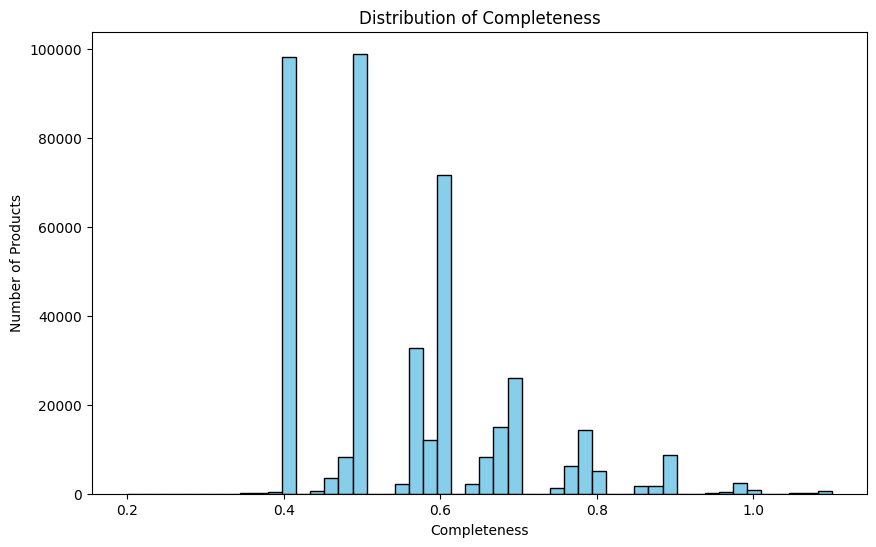

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df["completeness"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Completeness')
plt.xlabel('Completeness')
plt.ylabel('Number of Products')
plt.show()

##### `energy`: Energy per 100g

count    4.203170e+05
mean     1.467027e+14
std      9.511006e+16
min      0.000000e+00
25%      3.540000e+02
50%      1.100000e+03
75%      1.790000e+03
max      6.166162e+19
Name: energy, dtype: float64


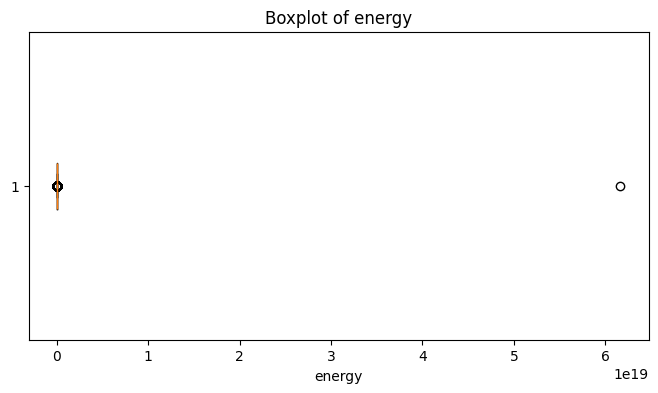

In [ ]:
# Summary statistics
print(df["energy"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["energy"].dropna(), vert=False)
plt.title("Boxplot of energy")
plt.xlabel("energy")
plt.show()


In [ ]:
df[df["energy"] > 500000][["product", "energy"]]

,product,energy
329189,Dorito Nacho Cheese,6.166162e+19


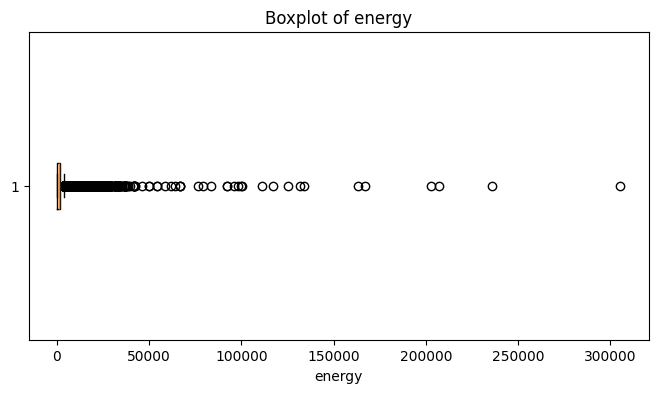

In [ ]:
# Boxplot (w/out outlier)
plt.figure(figsize=(8,4))
plt.boxplot(df[df["energy"]<500000]["energy"].dropna(), vert=False)
plt.title("Boxplot of energy")
plt.xlabel("energy")
plt.show()

##### `sugars`: Sugar per 100g

count    4.112610e+05
mean     2.431564e+06
std      1.559341e+09
min     -1.450000e+00
25%      1.180000e+00
50%      5.040000e+00
75%      2.267000e+01
max      1.000000e+12
Name: sugars, dtype: float64


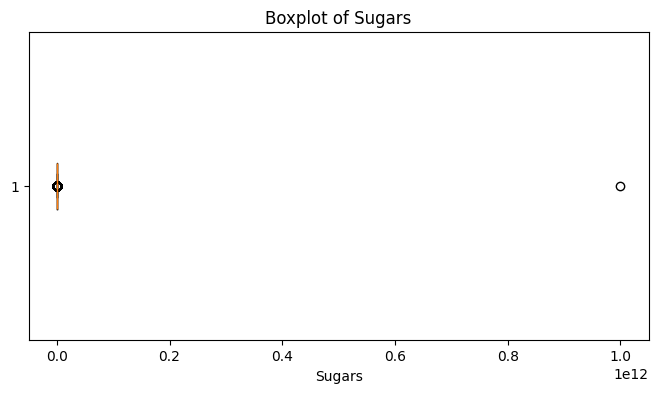

In [ ]:
# Summary statistics
print(df["sugars"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["sugars"].dropna(), vert=False)
plt.title("Boxplot of Sugars")
plt.xlabel("Sugars")
plt.show()


In [ ]:
df[df["sugars"] > 500000][["product", "sugars"]]

,product,sugars
329189,Dorito Nacho Cheese,1.000000e+12


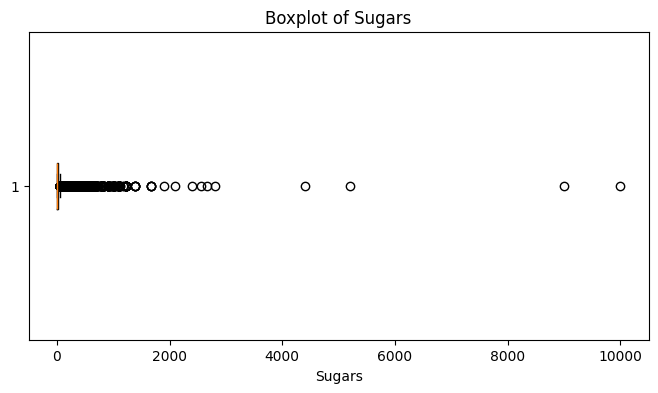

In [ ]:
# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df[df["sugars"]<500000]["sugars"].dropna(), vert=False)
plt.title("Boxplot of Sugars")
plt.xlabel("Sugars")
plt.show()


##### `added_sugar`: Added sugar per 100g

count    24834.000000
mean        12.756229
std         98.991081
min          0.000000
25%          0.000000
50%          0.000000
75%         11.200000
max       9000.000000
Name: added_sugars, dtype: float64


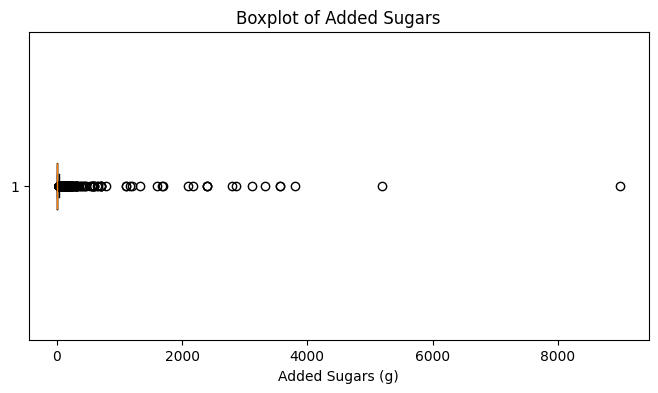

In [ ]:
# Summary statistics
print(df["added_sugars"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["added_sugars"].dropna(), vert=False)
plt.title("Boxplot of Added Sugars")
plt.xlabel("Added Sugars (g)")
plt.show()


In [ ]:
df[df["added_sugars"] > 8000][["product", "added_sugars"]]

,product,added_sugars
359308,Matcha Latte Vanilla,9000.0


##### `carbohydrates`: Carbohydrates per 100g

count    4.194930e+05
mean     1.183488e+25
std      7.665248e+27
min      0.000000e+00
25%      6.250000e+00
50%      2.240000e+01
75%      5.850000e+01
max      4.964649e+30
Name: carbohydrates, dtype: float64


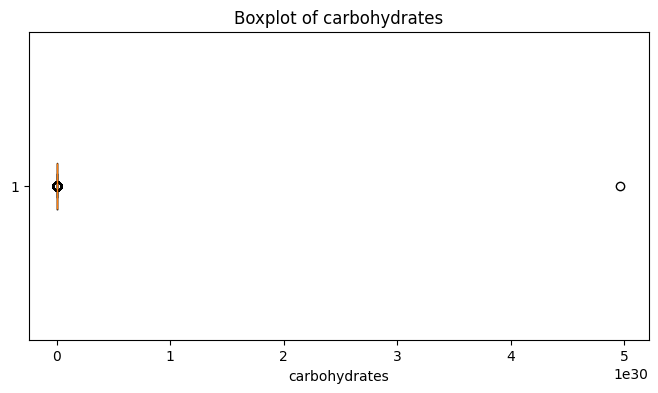

In [ ]:
# Summary statistics
print(df["carbohydrates"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["carbohydrates"].dropna(), vert=False)
plt.title("Boxplot of carbohydrates")
plt.xlabel("carbohydrates")
plt.show()

In [ ]:
df[df["carbohydrates"] > 70000][["product", "carbohydrates"]]

,product,carbohydrates
329189,Dorito Nacho Cheese,4.964649e+30
423716,sirop de zahar,7.785800e+04


count    4.194930e+05
mean     1.183488e+25
std      7.665248e+27
min      0.000000e+00
25%      6.250000e+00
50%      2.240000e+01
75%      5.850000e+01
max      4.964649e+30
Name: carbohydrates, dtype: float64


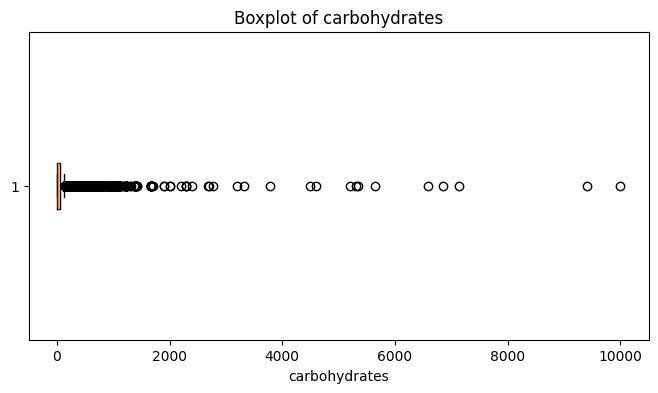

In [ ]:
# Summary statistics
print(df["carbohydrates"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df[df["carbohydrates"]<70000]["carbohydrates"].dropna(), vert=False)
plt.title("Boxplot of carbohydrates")
plt.xlabel("carbohydrates")
plt.show()

##### `salt`: Salt per 100g

count    420181.000000
mean          3.856932
std         601.940268
min           0.000000
25%           0.025900
50%           0.450000
75%           1.250000
max      355942.500000
Name: salt, dtype: float64


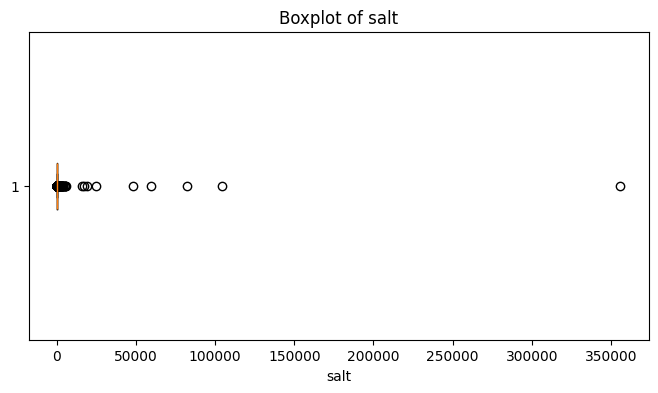

In [ ]:
# Summary statistics
print(df["salt"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["salt"].dropna(), vert=False)
plt.title("Boxplot of salt")
plt.xlabel("salt")
plt.show()

In [ ]:
df[df["salt"] > 40000][["brands", "product", "salt"]]

,brands,product,salt
116,Olde Thompson,Mediterranean Sea Salt,104167.5
1101,Kroger,Celery Salt,82142.5
1103,Kroger,Garlic Salt,59375.0
1210,Private Selection,Garlic & Sea Salt Grinder,47917.5
334583,Balaji,wheels,355942.5


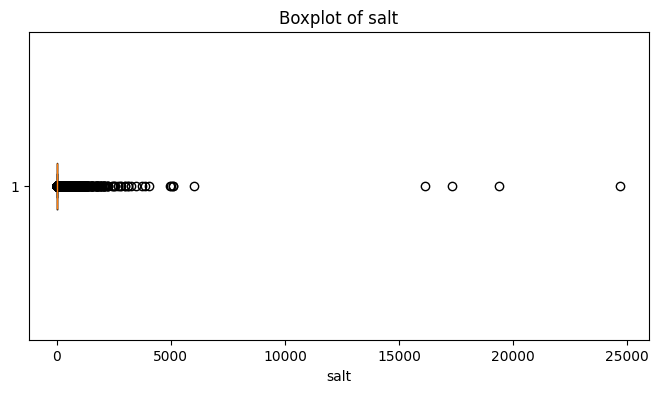

In [ ]:
# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df[df["salt"]<40000]["salt"].dropna(), vert=False)
plt.title("Boxplot of salt")
plt.xlabel("salt")
plt.show()

##### `fat`: Fat per 100

count    4.202950e+05
mean     1.105549e+20
std      7.167291e+22
min      0.000000e+00
25%      0.000000e+00
50%      5.900000e+00
75%      2.100000e+01
max      4.646567e+25
Name: fat, dtype: float64


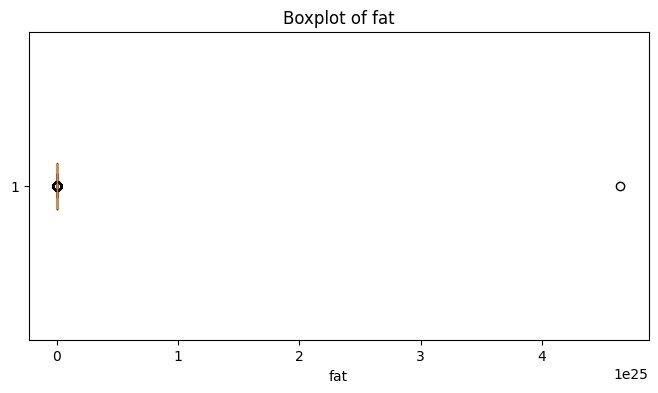

In [ ]:
# Summary statistics
print(df["fat"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["fat"].dropna(), vert=False)
plt.title("Boxplot of fat")
plt.xlabel("fat")
plt.show()

In [ ]:
df[df["fat"] > 100000][["brands", "product", "fat"]]

,brands,product,fat
329189,Doritos,Dorito Nacho Cheese,4.646567e+25
354745,Faber-Castel,Faber-Castel knetradiergummi,6.784540e+05


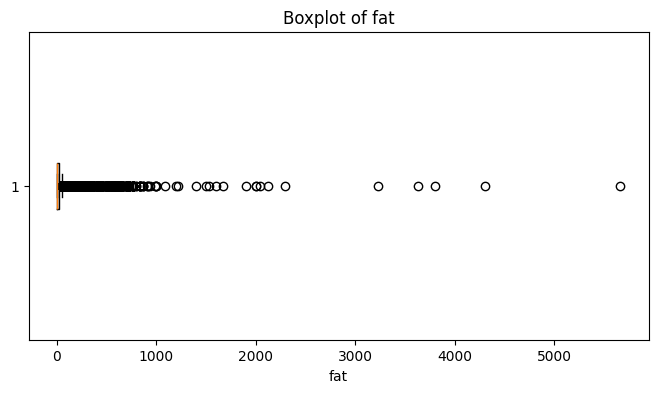

In [ ]:
# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df[df["fat"] < 100000]["fat"].dropna(), vert=False)
plt.title("Boxplot of fat")
plt.xlabel("fat")
plt.show()

##### `trans_fat`: Trans fat per 100g

count    250302.000000
mean          0.058966
std           1.370468
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         153.000000
Name: trans_fat, dtype: float64


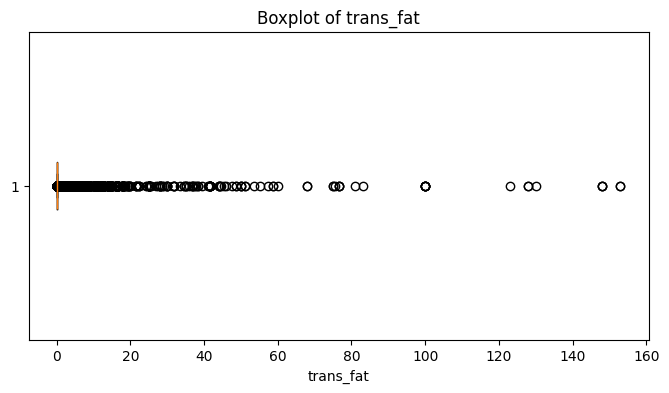

In [ ]:
# Summary statistics
print(df["trans_fat"].describe())

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df["trans_fat"].dropna(), vert=False)
plt.title("Boxplot of trans_fat")
plt.xlabel("trans_fat")
plt.show()

##### **`nutriscore_grade`**: Nutritional score grade (a,b,c,d,e)

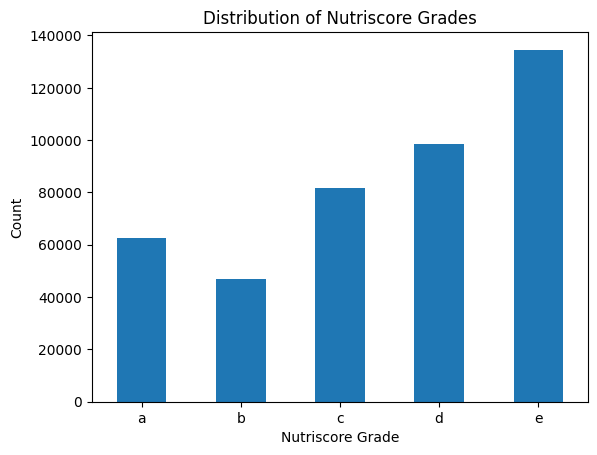

{'a': 62500, 'b': 47033, 'c': 81611, 'd': 98591, 'e': 134562}


,Count,Percentage (%)
nutriscore_grade,,
a,62500,14.7
b,47033,11.1
c,81611,19.2
d,98591,23.2
e,134562,31.7


In [ ]:
# Target Variable is nutriscore_grade
# plot distribution of nutriscore grades
grade_order = ["a", "b", "c", "d", "e"]
counts = df["nutriscore_grade"].value_counts().reindex(grade_order)
counts.plot(kind="bar")
plt.xlabel("Nutriscore Grade")
plt.ylabel("Count")
plt.title("Distribution of Nutriscore Grades")
plt.xticks(rotation=0)
plt.show()
print(counts.to_dict())

# Count and percentage
counts = df["nutriscore_grade"].value_counts().reindex(grade_order)
percentages = (counts / counts.sum() * 100).round(1)

# Combine into a summary DataFrame
nutriscore_summary = pd.DataFrame({
    "Count": counts.astype(int),
    "Percentage (%)": percentages
})
display(nutriscore_summary)

Nutri-Score classes: a, b, c, d, e (ordinal scale).

- Most products fall under d (23%) and d (32%), indicating poorer nutritional quality.
- a (15%) and b (11%) represent healthier foods.
- Class imbalance exists — will address it in data preprocessing.

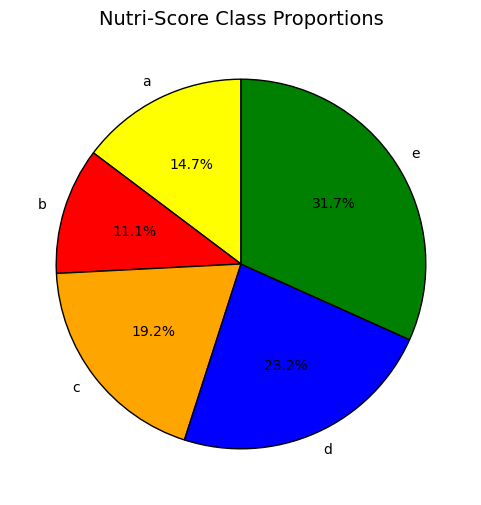

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(counts, labels=grade_order, autopct='%1.1f%%', startangle=90,
        colors=["yellow","red","orange","blue","green"],
        wedgeprops={'edgecolor':'black'})
plt.title("Nutri-Score Class Proportions", fontsize=14)
plt.show()


The pie chart reinforces the imbalance:
- The blue/green slices (d, e) dominate the dataset.
- Healthy classes a and b occupy smaller areas.
- This imbalance might affect model learning and should be taken into consideration.

### Missing Values

In [ ]:
# missing values per column
df.isnull().sum()

code                                  0
brands                           116939
product                              12
lang                                  0
categories_tags                       0
food_groups_tags                      0
labels_tags                      305699
additives_n                           1
additives_tags                        0
allergens_tags                        0
ingredients_analysis_tags            99
ingredients_n                         1
ingredients_from_palm_oil_n       85832
ingredients                           0
completeness                          0
energy                             3980
sugars                            13036
added_sugars                     399463
carbohydrates                      4804
salt                               4116
fat                                4002
trans_fat                        173995
proteins                           4015
nutriscore_grade                      0
num_categories_tags                   0


In [ ]:
# Missing values count and percent
missing = df.isnull().sum()
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Missing Values": missing, "Missing %": missing_percent})
display(missing_df.sort_values("Missing %", ascending=False))

# Duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")


,Missing Values,Missing %
added_sugars,399463,94.15
labels_tags,305699,72.05
trans_fat,173995,41.01
brands,116939,27.56
ingredients_from_palm_oil_n,85832,20.23
sugars,13036,3.07
carbohydrates,4804,1.13
salt,4116,0.97
proteins,4015,0.95
fat,4002,0.94



Duplicate rows: 0


- High missingness in: added_sugars (94%), labels_tags (72%), trans_fat (41%),brands (28%), and ingredients_from_palm_oil_n(20&).
- Low missingness (<3%) in main nutrient columns including sugar, carbohydrates, salts, proteins, energy, fat, and etc.
- No duplicate rows detected.

### Correlation and Trends

In [ ]:
# Select numeric columns
num_cols = [
    "additives_n", "ingredients_n", "ingredients_from_palm_oil_n",
    "completeness", "energy", "sugars", "added_sugars",
    "carbohydrates", "salt", "fat", "trans_fat", "proteins"
]

# Make sure columns exist
num_cols = [col for col in num_cols if col in df.columns]

# Convert everything to float
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create cleaned dataframe for correlation
corr_df = df[num_cols].replace([np.inf, -np.inf], np.nan).dropna()

print(f"Correlation dataframe ready: {corr_df.shape}")
print("Numeric columns included:", list(corr_df.columns))

Correlation dataframe ready: (11876, 12)
Numeric columns included: ['additives_n', 'ingredients_n', 'ingredients_from_palm_oil_n', 'completeness', 'energy', 'sugars', 'added_sugars', 'carbohydrates', 'salt', 'fat', 'trans_fat', 'proteins']


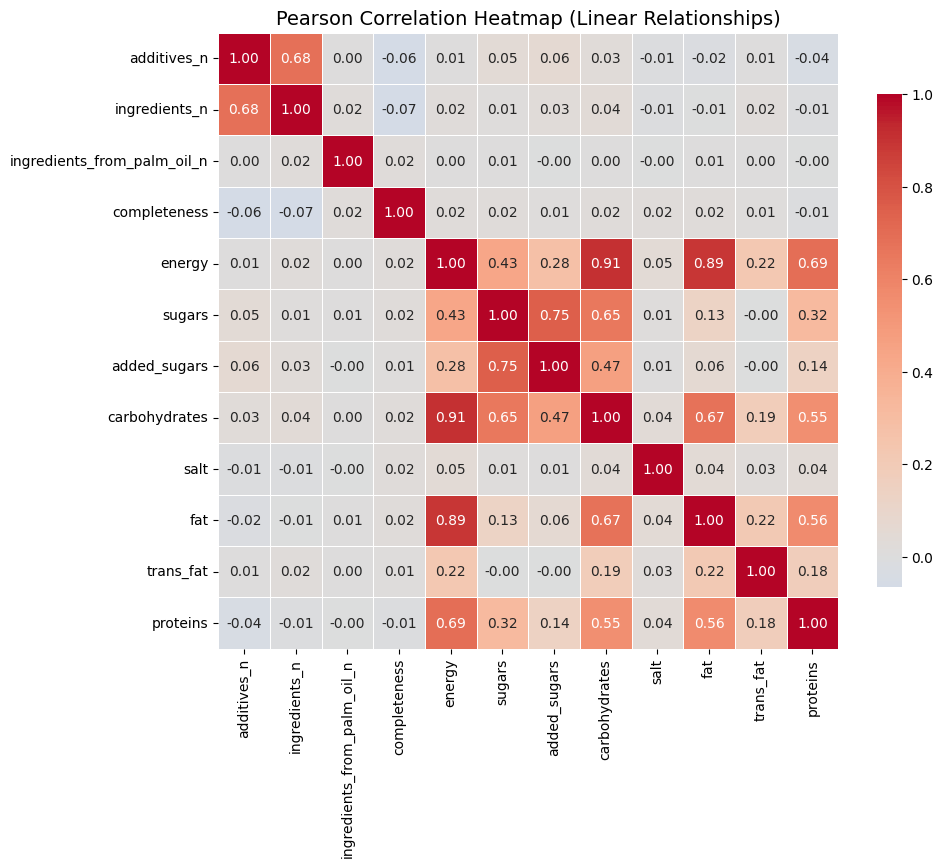

In [ ]:
# Pearson Correlation
corr_pearson = corr_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_pearson, annot=True, fmt=".2f",
    cmap="coolwarm", center=0, linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title("Pearson Correlation Heatmap (Linear Relationships)", fontsize=14)
plt.show()


**Strong Positive Correlations**

Energy and carbohydrates (0.91)
Higher carbohydrate content strongly increases total energy which is expected, since carbs are a main calorie source.

Energy and fat (0.89)
Fat also contributes heavily to total energy (9 kcal/g), showing similar influence.

Energy and proteins (0.69)
Moderate correlation: high-protein foods also add energy, but less than fat/carbs.

Carbohydrates and sugars (0.65)
Many carbohydrates are from sugars, especially in processed foods.


**Moderate or Low Correlations**

Completeness is mostly uncorrelated since it measures data completeness (a metadata quality flag), not a nutritional attribute.

Additives_n and ingredients_n (0.68) show products with more ingredients tend to have more additives, logical for complex processed foods.

Salt and Sugar (0.01) shows minimal correlation since salty and sweet products are usually distinct categories.

**Negative Correlations**

No strong negative trends appear since most features move independently or positively which makes sense nutritionally.

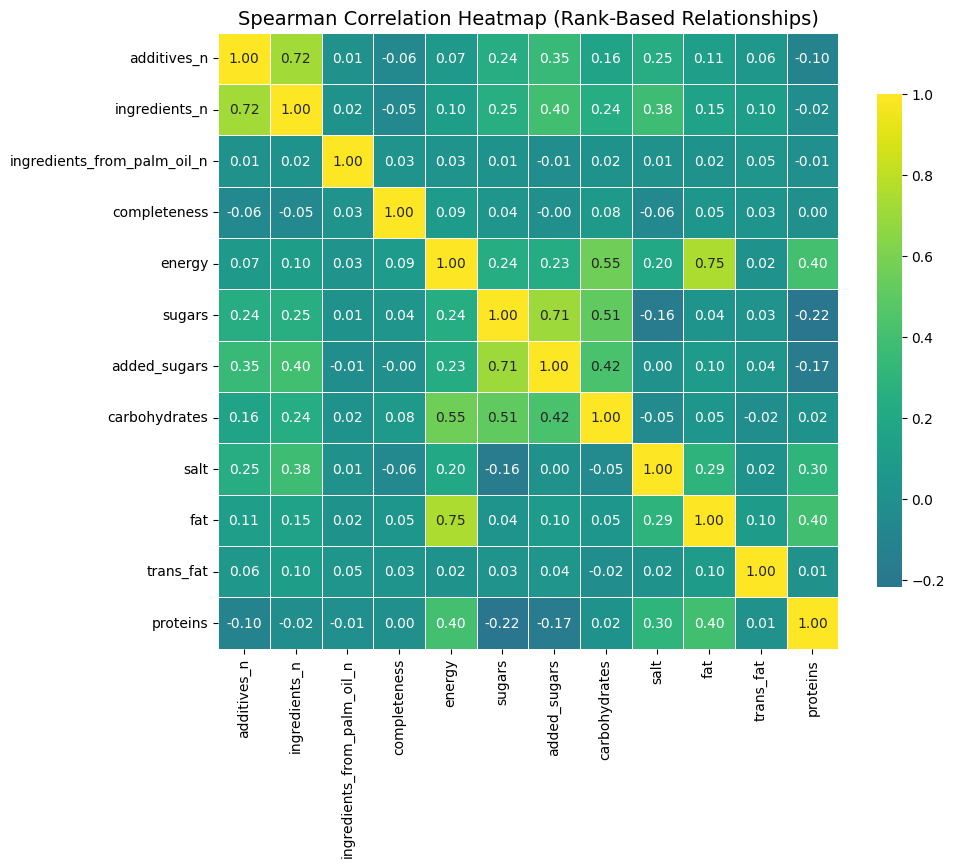

In [ ]:
# Spearman Correlation
corr_spearman = corr_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman, annot=True, fmt=".2f", cmap="viridis",
    center=0, linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title("Spearman Correlation Heatmap (Rank-Based Relationships)", fontsize=14)
plt.show()

The Spearman correlation captures monotonic relationships.

**Strong Positive Correlations**
Additives_n and ingredients_n	(0.72): Foods with more ingredients tend to include more additives which is typical of complex, processed products.

Sugars and added_sugars	(0.71): Strong and expected since added sugars are a subset of total sugars.

Energy and fat	(0.75):	Fat contributes significantly to total energy (9 kcal/g), so this strong correlation is logical.

**Moderate Positive Correlations**
Energy and proteins	(0.40):	Protein contributes to total energy content, but less so than fat.

Carbohydrates and sugars(0.51):	Sugars are a form of carbohydrate, so they tend to rise together.

Added_sugars and carbohydrates	(0.42):	Foods high in added sugar are generally high in total carbohydrate content.

**Weak Correlations**
Salt and other nutrients:	Very weak since salty products are nutritionally distinct from sweet/fatty ones.

Completeness and others: Near 0 since “completeness” measures data coverage, not nutrition.

Trans_fat and other nutrients:	Low correlation since trans fat presence is more regulatory than nutritional.

**Weak Negative Correlation**
Proteins and sugars (-0.22):	High-protein foods (e.g., meats, dairy) tend to be low in sugar which is common dietary trade-off.

In [ ]:
# Top Correlated Pairs
top_corr_pairs = (
    corr_pearson.unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)

top_corr_pairs = top_corr_pairs[top_corr_pairs < 0.999]  # remove self-corr
print("\nTop correlated variable pairs:")
for (a, b), val in top_corr_pairs.head(5).items():
    print(f"{a} and {b}: correlation = {val:.2f}")


Top correlated variable pairs:
energy and carbohydrates: correlation = 0.91
energy and fat: correlation = 0.89
sugars and added_sugars: correlation = 0.75
energy and proteins: correlation = 0.69
ingredients_n and additives_n: correlation = 0.68


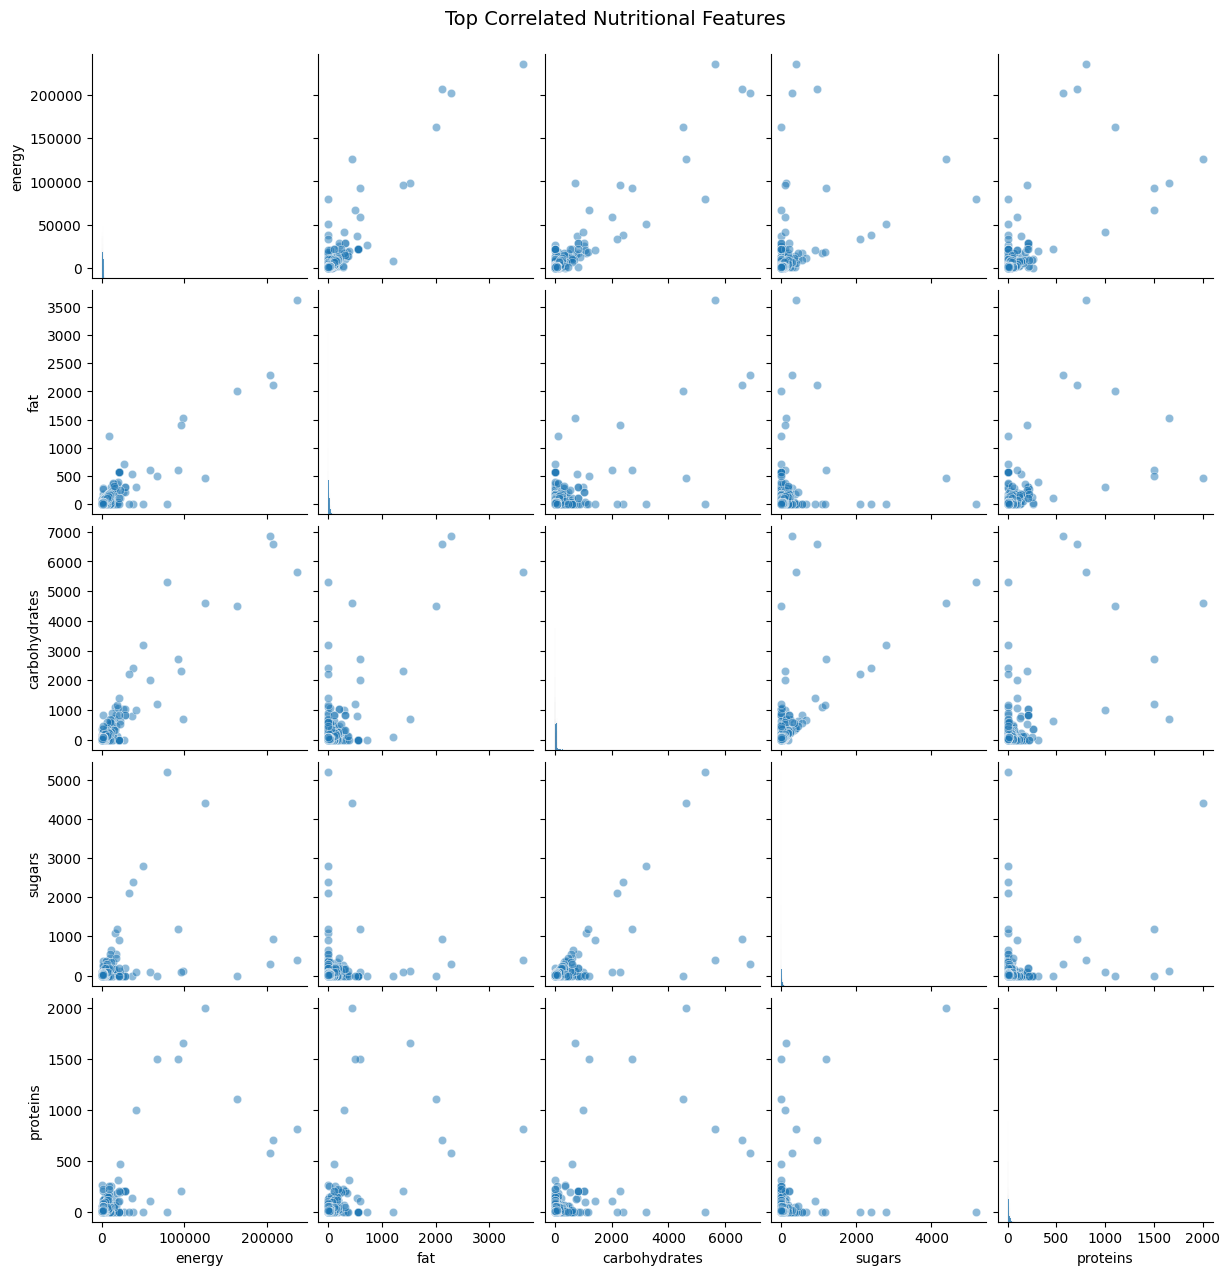

In [ ]:
# Pairwise Scatter Plot Visualization
# Select columns to visualize — adjust as needed
cols_to_plot = ["energy", "fat", "carbohydrates", "sugars", "proteins"]

# Pairwise scatter plot matrix
sns.pairplot(corr_df[cols_to_plot], diag_kind="hist", plot_kws={"alpha": 0.5})
plt.suptitle("Top Correlated Nutritional Features", y=1.02, fontsize=14)
plt.show()


Each cell compares two nutrient variables from
["energy", "fat", "carbohydrates", "sugars", "proteins"].
The diagonal shows histograms; off-diagonal plots show relationships between nutrients.

Key Observations
Energy vs. Fat: Strong positive trend. As fat content increases, energy (caloric value) also rises sharply. Fat-rich foods (e.g., oils, spreads) contribute most to total calories.

Energy vs. Carbohydrates: Positive correlation, though with more scatter than fat. Carbohydrates also contribute to total energy, but their effect varies depending on product type (e.g., sugary vs. fibrous foods).

Energy vs. Sugars: Moderate relationship, but visibly weaker than fat or carbs.
Sugary foods increase calories. but sugar content alone is not the only driver of energy while many low-sugar items are still high-energy due to fats.

Energy vs. Protein: Mild positive correlation, higher-protein foods generally have more energy. Protein-rich foods contribute to total energy but are less dominant than fat or carbs.

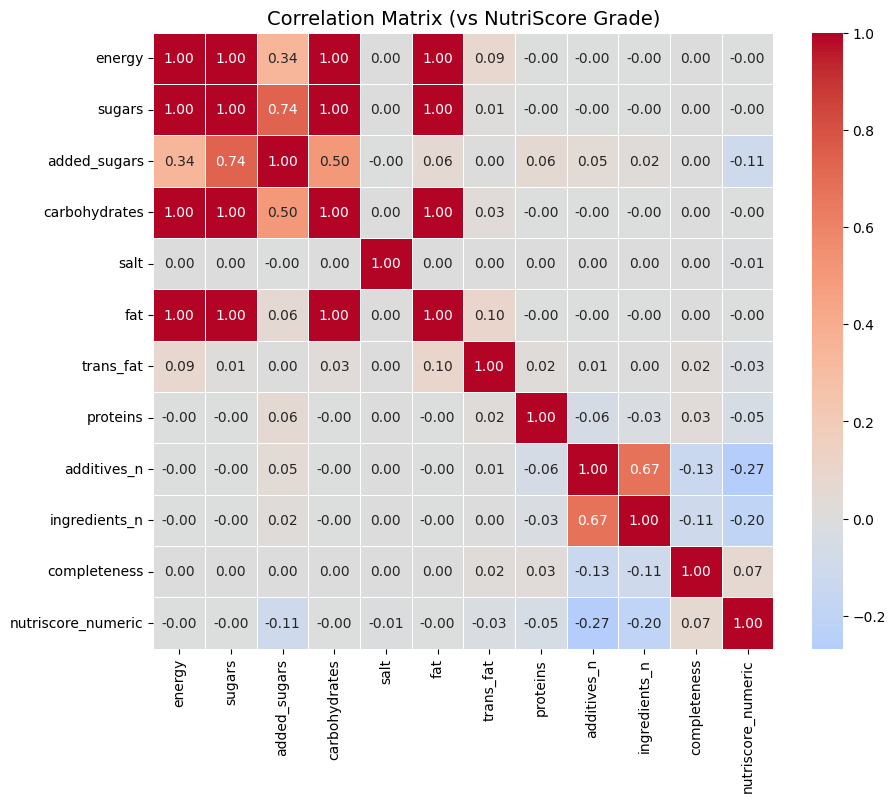

Correlation of each nutrient with NutriScore (higher = healthier):
nutriscore_numeric    1.000000
completeness          0.068938
energy               -0.001679
fat                  -0.001679
carbohydrates        -0.001680
sugars               -0.001693
salt                 -0.005852
trans_fat            -0.026622
proteins             -0.053962
added_sugars         -0.107056
ingredients_n        -0.199724
additives_n          -0.267426
Name: nutriscore_numeric, dtype: float64


In [ ]:
# Map nutriscore letters to numeric scale
nutri_map = {"a": 5, "b": 4, "c": 3, "d": 2, "e": 1}
df["nutriscore_numeric"] = df["nutriscore_grade"].map(nutri_map)

# Select numeric nutrient columns + NutriScore
num_cols = [
    "energy", "sugars", "added_sugars", "carbohydrates", "salt",
    "fat", "trans_fat", "proteins", "additives_n", "ingredients_n", "completeness", "nutriscore_numeric"
]

corr_focus = df[num_cols].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_focus, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix (vs NutriScore Grade)", fontsize=14)
plt.show()

# Sort correlations with NutriScore only
nutri_corr = corr_focus["nutriscore_numeric"].sort_values(ascending=False)
print("Correlation of each nutrient with NutriScore (higher = healthier):")
print(nutri_corr)


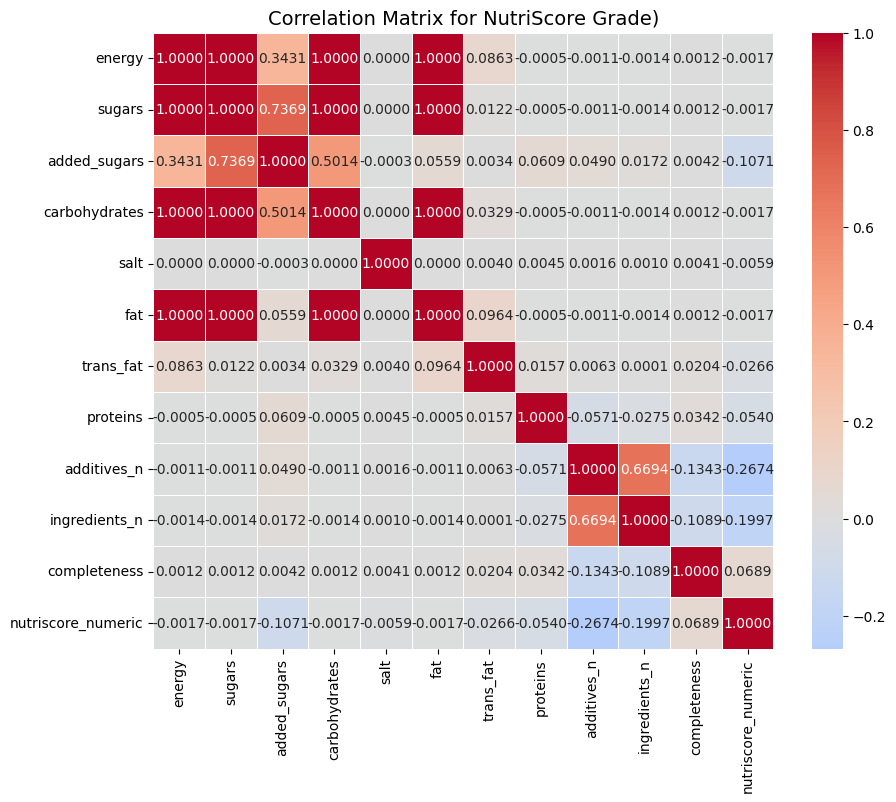

Correlation of each nutrient with NutriScore (higher = healthier):
nutriscore_numeric    1.000000
completeness          0.068938
energy               -0.001679
fat                  -0.001679
carbohydrates        -0.001680
sugars               -0.001693
salt                 -0.005852
trans_fat            -0.026622
proteins             -0.053962
added_sugars         -0.107056
ingredients_n        -0.199724
additives_n          -0.267426
Name: nutriscore_numeric, dtype: float64


In [ ]:
# Map nutriscore letters to numeric scale
nutri_map = {"a": 5, "b": 4, "c": 3, "d": 2, "e": 1}
df["nutriscore_numeric"] = df["nutriscore_grade"].map(nutri_map)

# Select numeric nutrient columns + NutriScore
num_cols = [
    "energy", "sugars", "added_sugars", "carbohydrates", "salt",
    "fat", "trans_fat", "proteins", "additives_n", "ingredients_n", "completeness", "nutriscore_numeric"
]

corr_focus = df[num_cols].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_focus, annot=True, fmt=".4f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix for NutriScore Grade)", fontsize=14)
plt.show()

# Sort correlations with NutriScore only
nutri_corr = corr_focus["nutriscore_numeric"].sort_values(ascending=False)
print("Correlation of each nutrient with NutriScore (higher = healthier):")
print(nutri_corr)


Completeness (0.068920): Slight positive correlation. Foods with more complete data entries tend to have marginally better NutriScores.

Energy (-0.001679): No meaningful relationship. Caloric density alone doesn’t significantly affect NutriScore in this dataset.

Fat (-0.001678): No notable trend. Fat content by itself does not strongly predict NutriScore.

Carbohydrates (-0.001680): No meaningful relationship. Carbohydrate content shows minimal impact on health score.

Sugars (-0.001693): Slightly negative but very weak correlation. Total sugar content is not a major determinant here.

Salt (-0.005851): Very weak negative correlation. High salt levels only slightly reduce NutriScore.

Trans Fat (-0.026646): Weak negative correlation. Foods with trans fats tend to be less healthy.

Proteins (-0.053932): Slight negative correlation. Possibly due to some high-protein but processed foods (like meats).

Added Sugars (-0.107596): Noticeable negative correlation. Foods high in added sugars generally score worse.

Ingredients_n (-0.199823): Moderate negative correlation. Foods with long ingredient lists are often more processed and less healthy.

Additives_n (-0.267453): Strongest negative correlation. A higher number of additives is closely associated with poor NutriScores (D/E).